In [458]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm

In [459]:
plt.rcParams['figure.figsize'] = [6, 8]
tfont = {'family': 'monospace',
         'color':  'black',
         'weight': 'heavy',
         'size': 22}

# Подготовка данных 

In [1]:
%cd ./Downloads

/Users/pavelkiselev/Downloads


In [461]:
df = pd.read_csv('data.csv', sep=',')
df.shape

(10000, 7)

In [462]:
df.head()

,id,required_amt,installment_flg,monthly_income_amt,age,has_high_education_flg,approved_flg
0,1,23906.0,0,80000,37,0,0
1,2,13111.0,1,43000,22,0,0
2,3,43266.0,1,20000,34,0,0
3,4,68782.0,1,35000,24,0,0
4,5,19550.0,1,25000,42,1,0


In [463]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9998 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9998 non-null   int64  
 1   required_amt            9998 non-null   float64
 2   installment_flg         9998 non-null   int64  
 3   monthly_income_amt      9998 non-null   int64  
 4   age                     9998 non-null   int64  
 5   has_high_education_flg  9998 non-null   int64  
 6   approved_flg            9998 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 624.9 KB


# Предсказательные интервалы

Построим предсказательные интервалы для ежемесячного дохода и запрошенной суммы в предположении их логнормальности. Т.е. если $X$ — запрошенная сумма, то
$$ X = e^V, \text{ где } V \sim \cal{N} (\mu, \sigma).$$ 
Вместо неизвестных $\mu$ и $\sigma$ будем использовать их несмещенные оценки:
$$ \mu \approx \bar{V}_n = \frac{V_1 + \cdots + V_n}{n} \\
\sigma \approx S_n = \frac{1}{n-1} \sum_{i=1}^{n} (V_i - \bar{V}_n)^2 = \frac{1}{n-1} \sum_{i=1}^{n} (\ln{X_i} - \bar{V}_n)^2. $$
Тогда предсказательный интервал для $V$ имеет вид:
$$ [\bar{V}_n - z_{1-\alpha/2}S_n -  \bar{V}_n + z_{1-\alpha/2}S_n],$$
для $X$:
$$ [\exp(\bar{V}_n - z_{1-\alpha/2}S_n) -  \exp(\bar{V}_n + z_{1-\alpha/2}S_n)].$$

In [464]:
log_monthly_income_conf_int = _zconfint_generic(np.log(df.monthly_income_amt).mean(),
                                                np.log(df.monthly_income_amt).std(),
                                                0.05,
                                                'two-sided')

log_required_conf_int = _zconfint_generic(np.log(df.required_amt).mean(),
                                          np.log(df.required_amt).std(),
                                          0.05,
                                          'two-sided')

monthly_income_conf_int = np.exp(log_monthly_income_conf_int)

required_conf_int = np.exp(log_required_conf_int)


print(f'monthly_income_amt 95% confidence interval: \
      [{monthly_income_conf_int[0]:,.0f} - {monthly_income_conf_int[1]:,.0f}]')
      
print(f'required_amt 95% confidence interval: \
      [{required_conf_int[0]:,.0f} - {required_conf_int[1]:,.0f}]')

monthly_income_amt 95% confidence interval:       [13,008 - 119,867]
required_amt 95% confidence interval:       [6,678 - 124,715]


# Разделение рисков

## Категориальные признаки

Построим доверительные интервалы для approved_flg по каждому признаку. Для категориальных признаков разобьем выборку на две подвыборки. И для каждой подвыборки построим доверительные интервалы, а затем сравним их.

In [465]:
educated_client_approved_conf_int = proportion_confint(df[df.has_high_education_flg == 1].approved_flg.sum(),
                                                       len(df[df.has_high_education_flg == 1].approved_flg),
                                                       alpha = 0.01,
                                                       method = 'wilson')

not_educated_client_approved_conf_int = proportion_confint(df[df.has_high_education_flg == 0].approved_flg.sum(),
                                                           len(df[df.has_high_education_flg == 0].approved_flg),
                                                           alpha = 0.01,
                                                           method = 'wilson')

print(f'educated client approved 99% confidence interval: \
      [{educated_client_approved_conf_int[0]:.3f} - {educated_client_approved_conf_int[1]:.3f}]')

print(f'not educated client approved 99% confidence interval: \
      [{not_educated_client_approved_conf_int[0]:.3f} - {educated_client_approved_conf_int[1]:.3f}]')

educated client approved 99% confidence interval:       [0.307 - 0.348]
not educated client approved 99% confidence interval:       [0.212 - 0.348]


Интервалы пересекаются — однозначного вывода на уровне значимости 99% сделать нельзя. Построим интервал на разность долей.

In [466]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.01):
    '''Считает доверительный интервал для разности долей в независимых выборках'''
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    sigma = np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    left_boundary = (p1 - p2) - z * sigma
    right_boundary = (p1 - p2) + z * sigma
    return (left_boundary, right_boundary)

In [467]:
proportions_confint_diff_ind(df[df.has_high_education_flg == 1].approved_flg,
                             df[df.has_high_education_flg == 0].approved_flg)

(0.07799488990081878, 0.12672037014015905)

Т.к. интервал не содержить нуля, можно сделать вывод о том, что признак высшего образования разделяет риски на уровне значимости 99%.

Аналогично строим интервалы для approved_flg по признаку рассрочки/кредита.

In [468]:
installment_client_approved_conf_int = proportion_confint(df[df.installment_flg == 1].approved_flg.sum(),
                                                    len(df[df.installment_flg == 1].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')

print(f'installment client approved 99% confidence interval: [{installment_client_approved_conf_int[0]:.3f} - {installment_client_approved_conf_int[1]:.3f}]')

installment client approved 99% confidence interval: [0.247 - 0.275]


In [469]:
credit_client_approved_conf_int = proportion_confint(df[df.installment_flg == 0].approved_flg.sum(),
                                                    len(df[df.installment_flg == 0].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')

print(f'credit client approved 99% confidence interval: [{credit_client_approved_conf_int[0]:.3f} - {credit_client_approved_conf_int[1]:.3f}]')

credit client approved 99% confidence interval: [0.244 - 0.281]


In [470]:
proportions_confint_diff_ind(df[df.installment_flg == 1].approved_flg,
                             df[df.installment_flg == 0].approved_flg)

(-0.024484187147299566, 0.0222959707974721)

Делаем вывод о том, что признак рассрочки/кредита не разделяет риски на уровне значимости 99%.

## Вещественные признаки

Далее построим доверительные интервалы для вещественных признаков. Для этого разобьем выбору по бакетам. Т.к. размер выборки небольшой, разбивку сделаем на четыре равные части по квантилям 0.25, 0.5, 0.75.

In [471]:
monthly_income_ctg = pd.qcut(df.monthly_income_amt, q=4).rename("monthly_income_ctg")

df_inc = pd.concat([df.monthly_income_amt, monthly_income_ctg, df.approved_flg], axis=1)
df_inc

,monthly_income_amt,monthly_income_ctg,approved_flg
0,80000,"(55000.0, 1500000.0]",0
1,43000,"(40000.0, 55000.0]",0
2,20000,"(21.999, 28000.0]",0
3,35000,"(28000.0, 40000.0]",0
4,25000,"(21.999, 28000.0]",0
...,...,...,...
9995,28000,"(21.999, 28000.0]",0
9996,30000,"(28000.0, 40000.0]",1
9997,31000,"(28000.0, 40000.0]",1
9998,70000,"(55000.0, 1500000.0]",1


income (21.999, 28000.0]    client approved 99% confidence interval:           [0.250 - 0.296]
income (28000.0, 40000.0]   client approved 99% confidence interval:           [0.241 - 0.281]
income (40000.0, 55000.0]   client approved 99% confidence interval:           [0.218 - 0.267]
income (55000.0, 1500000.0] client approved 99% confidence interval:           [0.244 - 0.291]


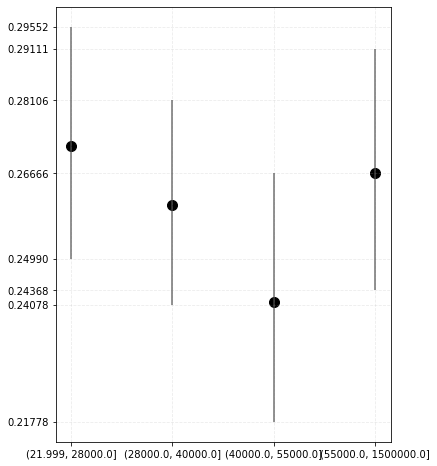

In [472]:
ci_bounds = []

for ctg in sorted(monthly_income_ctg.unique()):
    inc_ctg_data = df_inc[df_inc.monthly_income_ctg == ctg].approved_flg
    
    income_client_approved_conf_int = proportion_confint(inc_ctg_data.sum(), len(inc_ctg_data),
                                                         alpha = 0.01,
                                                         method = 'wilson')

    print(f'income {str(ctg):20} client approved 99% confidence interval: \
          [{income_client_approved_conf_int[0]:.3f} - {income_client_approved_conf_int[1]:.3f}]')
    
    plt.vlines(str(ctg), *income_client_approved_conf_int, color=".3", alpha=0.8)
    plt.scatter(y=inc_ctg_data.mean(), x=str(ctg), s=100, color=".0")
    
    ci_bounds.extend(income_client_approved_conf_int)
    
plt.yticks(ci_bounds)
plt.grid(True, linestyle='--', alpha=0.25)

Признак нахождения в одной из четырех категорий не разделяет риски на уровне значимости 99%, но можно заметить что категория "income (40000.0, 55000.0]" имеет значительно меньше одобрений. Проверим гипотезу, что признак нахожения в категории "income (40000.0, 55000.0]" разделяет риски. Для этого объеденим остальные три категории.

In [473]:
proportions_confint_diff_ind(df_inc[df_inc.monthly_income_ctg != sorted(monthly_income_ctg.unique())[2]].approved_flg,
                             df_inc[df_inc.monthly_income_ctg == sorted(monthly_income_ctg.unique())[2]].approved_flg,
                             alpha = 0.05)

(0.003568192263012193, 0.04555069708749321)

Действительно, признак нахожения в категории "income (40000.0, 55000.0]" разделяет риски на уровне значимости 99%.

Далее аналогично исследуем запрошенную сумму.

In [474]:
required_ctg = pd.qcut(df.required_amt, q=4).rename("required_ctg")

df_req = pd.concat([df.required_amt, required_ctg, df.approved_flg], axis=1)
df_req

,required_amt,required_ctg,approved_flg
0,23906.0,"(16990.0, 27734.5]",0
1,13111.0,"(2179.999, 16990.0]",0
2,43266.0,"(27734.5, 52534.75]",0
3,68782.0,"(52534.75, 279788.0]",0
4,19550.0,"(16990.0, 27734.5]",0
...,...,...,...
9995,22999.0,"(16990.0, 27734.5]",0
9996,16178.0,"(2179.999, 16990.0]",1
9997,14400.0,"(2179.999, 16990.0]",1
9998,17121.0,"(16990.0, 27734.5]",1


required (2179.999, 16990.0]  client approved 99% confidence interval:           [0.320 - 0.369]
required (16990.0, 27734.5]   client approved 99% confidence interval:           [0.265 - 0.312]
required (27734.5, 52534.75]  client approved 99% confidence interval:           [0.233 - 0.278]
required (52534.75, 279788.0] client approved 99% confidence interval:           [0.139 - 0.176]


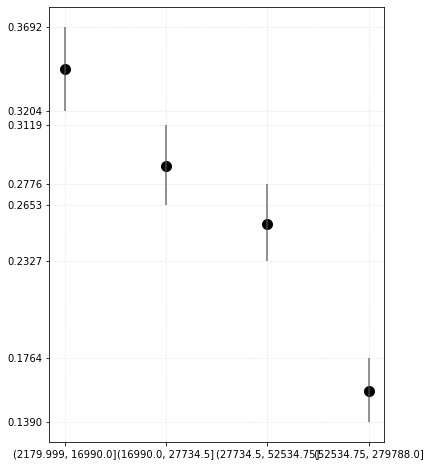

In [475]:
ci_bounds = []

for ctg in sorted(required_ctg.unique()):
    req_ctg_data = df_req[df_req.required_ctg == ctg].approved_flg
    
    required_client_approved_conf_int = proportion_confint(req_ctg_data.sum(), len(req_ctg_data),
                                                           alpha = 0.01,
                                                           method = 'wilson')

    print(f'required {str(ctg):20} client approved 99% confidence interval: \
          [{required_client_approved_conf_int[0]:.3f} - {required_client_approved_conf_int[1]:.3f}]')
    
    
    plt.vlines(str(ctg), *required_client_approved_conf_int, color=".3", alpha=0.8)
    plt.scatter(y=req_ctg_data.mean(), x=str(ctg), s=100, color=".0")
    
    ci_bounds.extend(required_client_approved_conf_int)
    
plt.yticks(ci_bounds)
plt.grid(True, linestyle='--', alpha=0.25)

Дополнительно проверим пересекающиеся интервалы.

In [476]:
proportions_confint_diff_ind(df_req[df_req.required_ctg == sorted(required_ctg.unique())[1]].approved_flg,
                             df_req[df_req.required_ctg == sorted(required_ctg.unique())[2]].approved_flg,
                             alpha = 0.01)

(0.0011725307893713927, 0.06594566264184722)

Следовательно, признак нахождения в одной из четырех категорий по запрошенной сумме разделяет риски на уровне значимости 99%. Чем выше запрошенная сумма — тем меньше вероятность одобрения.

Далее аналогично исследуем возраст заявителей.

In [477]:
age_ctg = pd.qcut(df.age, q=4).rename("age_ctg")

df_age = pd.concat([df.age, age_ctg, df.approved_flg], axis=1)
df_age

,age,age_ctg,approved_flg
0,37,"(30.0, 38.0]",0
1,22,"(17.999, 24.0]",0
2,34,"(30.0, 38.0]",0
3,24,"(17.999, 24.0]",0
4,42,"(38.0, 74.0]",0
...,...,...,...
9995,33,"(30.0, 38.0]",0
9996,37,"(30.0, 38.0]",1
9997,56,"(38.0, 74.0]",1
9998,29,"(24.0, 30.0]",1


age (17.999, 24.0]  client approved 99% confidence interval:           [0.104 - 0.135]
age (24.0, 30.0]    client approved 99% confidence interval:           [0.213 - 0.258]
age (30.0, 38.0]    client approved 99% confidence interval:           [0.296 - 0.346]
age (38.0, 74.0]    client approved 99% confidence interval:           [0.374 - 0.426]


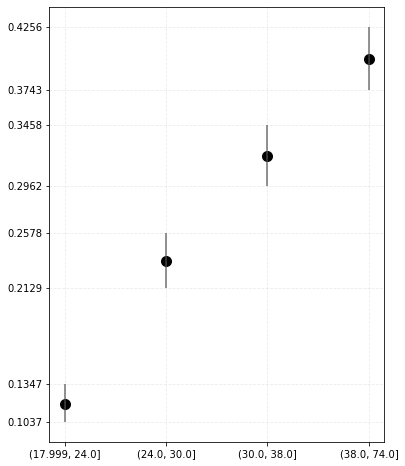

In [478]:
ci_bounds = []

for ctg in sorted(age_ctg.unique()):
    age_ctg_data = df_age[df_age.age_ctg == ctg].approved_flg
    
    age_client_approved_conf_int = proportion_confint(age_ctg_data.sum(), len(age_ctg_data),
                                                      alpha = 0.01,
                                                      method = 'wilson')

    print(f'age {str(ctg):15} client approved 99% confidence interval: \
          [{age_client_approved_conf_int[0]:.3f} - {age_client_approved_conf_int[1]:.3f}]')
    
    plt.vlines(str(ctg), *age_client_approved_conf_int, color=".3", alpha=0.8)
    plt.scatter(y=age_ctg_data.mean(), x=str(ctg), s=100, color=".0")
    
    ci_bounds.extend(age_client_approved_conf_int)
    
plt.yticks(ci_bounds)
plt.grid(True, linestyle='--', alpha=0.25)

Признак нахождения в одной из четырех категорий по возрасту разделяет риски на уровне значимости 99% — чем меньше возраст, тем меньше вероятность одобрения.

Далее добавим еще один признак к нашей таблице — отношение запрошенной суммы к зарплате. 

In [479]:
ratio = (df.required_amt / df.monthly_income_amt).rename("req_inc_ratio")
ratio

0       0.298825
1       0.304907
2       2.163300
3       1.965200
4       0.782000
          ...   
9995    0.821393
9996    0.539267
9997    0.464516
9998    0.244586
9999    0.450275
Name: req_inc_ratio, Length: 9998, dtype: float64

In [480]:
ratio_ctg = pd.qcut(ratio, q=4).rename("rec_inc_ratio_ctg")

df_ratio = pd.concat([ratio, ratio_ctg, df.approved_flg], axis=1)
df_ratio

,req_inc_ratio,rec_inc_ratio_ctg,approved_flg
0,0.298825,"(0.0163, 0.452]",0
1,0.304907,"(0.0163, 0.452]",0
2,2.163300,"(1.218, 1474.111]",0
3,1.965200,"(1.218, 1474.111]",0
4,0.782000,"(0.735, 1.218]",0
...,...,...,...
9995,0.821393,"(0.735, 1.218]",0
9996,0.539267,"(0.452, 0.735]",1
9997,0.464516,"(0.452, 0.735]",1
9998,0.244586,"(0.0163, 0.452]",1


ratio (0.0163, 0.452]      client approved 99% confidence interval:           [0.320 - 0.369]
ratio (0.452, 0.735]       client approved 99% confidence interval:           [0.270 - 0.317]
ratio (0.735, 1.218]       client approved 99% confidence interval:           [0.216 - 0.259]
ratio (1.218, 1474.111]    client approved 99% confidence interval:           [0.151 - 0.190]


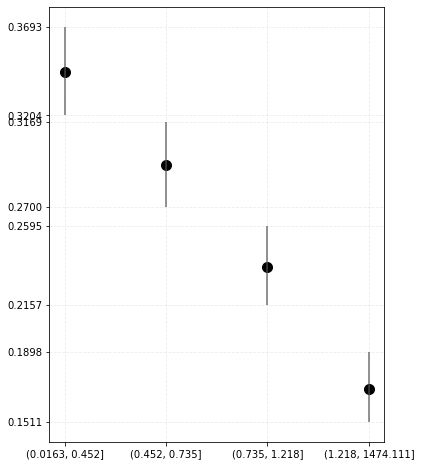

In [481]:
ci_bounds = []

for ctg in sorted(ratio_ctg.unique()):
    ratio_ctg_data = df_ratio[df_ratio.rec_inc_ratio_ctg == ctg].approved_flg
    
    ratio_client_approved_conf_int = proportion_confint(ratio_ctg_data.sum(), len(ratio_ctg_data),
                                                        alpha = 0.01,
                                                        method = 'wilson')

    print(f'ratio {str(ctg):20} client approved 99% confidence interval: \
          [{ratio_client_approved_conf_int[0]:.3f} - {ratio_client_approved_conf_int[1]:.3f}]')
    
    plt.vlines(str(ctg), *ratio_client_approved_conf_int, color=".3", alpha=0.8)
    plt.scatter(y=ratio_ctg_data.mean(), x=str(ctg), s=100, color=".0")
    
    ci_bounds.extend(ratio_client_approved_conf_int)
    
plt.yticks(ci_bounds)
plt.grid(True, linestyle='--', alpha=0.25)

Признак нахождения в одной из четырех категорий по отношению разпрошенная сумма/зарплата разделяет риски на уровне значимости 99%.